## 🧭 Notebook 4 — Machine Learning Models for Forecasting Hotel Demand

**Goals:**


---

### 🟩 1. Setup and Data Load

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import xgboost as xgb

import shap
import joblib
import json

import os
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided")
warnings.filterwarnings("ignore", message="Maximum Likelihood optimization failed to converge")

plt.style.use("seaborn-v0_8-whitegrid")
sns.set_context("talk")

# --- Load processed dataset with features ---
DATA_PATH = Path("../data/processed/hotel_panel_features.csv")

panel = pd.read_csv(DATA_PATH, parse_dates=["month"])
panel = panel.sort_values(["region", "month"])

print(f"[INFO] Loaded dataset with shape: {panel.shape}")
display(panel.head())

[INFO] Loaded dataset with shape: (3328, 39)


/Users/golibsanaev/Library/CloudStorage/Dropbox/GitHub_gsanaev/forecasting-explaining-hotel-demand-in-eu/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,region,month,year,nights_spent,gdp_lag1,gdp_lag2,gdp_lag3,unemployment_rate_lag1,unemployment_rate_lag2,unemployment_rate_lag3,...,turnover_index_mom,hicp_index_mom,gdp,unemployment_rate,turnover_index,hicp_index,covid_cases,policy_stringency,eurusd,eurgbp
0,AT,2015-01-31,2015,1833949.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,61688.900000,5.5,31.0,98.48,0.0,0.0,1.128796,0.748800
1,AT,2015-02-28,2015,2145686.0,61688.900000,NaN,NaN,5.5,NaN,NaN,...,0.0,0.274167,62111.133333,5.9,31.0,98.75,0.0,0.0,1.119796,0.726058
2,AT,2015-03-31,2015,1934635.0,62111.133333,61688.900000,NaN,5.9,5.5,NaN,...,0.0,1.417722,62533.366667,5.4,31.0,100.15,0.0,0.0,1.083025,0.731200
3,AT,2015-04-30,2015,1468507.0,62533.366667,62111.133333,61688.900000,5.4,5.9,5.5,...,0.0,0.129805,62955.600000,5.6,31.0,100.28,0.0,0.0,1.111432,0.720400
4,AT,2015-05-31,2015,1792973.0,62955.600000,62533.366667,62111.133333,5.6,5.4,5.9,...,0.0,0.169525,63353.033333,5.8,31.0,100.45,0.0,0.0,1.096035,0.715400


### 🟩 2. Data Preparation

In [2]:
# --- Define target and features ---
target = "nights_spent"

# Potential predictors (all lagged and macro variables)
feature_cols = [
    "gdp_lag1", "unemployment_rate_lag1", "turnover_index_lag1",
    "hicp_index_lag1", "covid_cases_lag1", "policy_stringency_lag1",
    "eurusd_lag1", "eurgbp_lag1"
]

# Keep only relevant columns and drop missing rows
data = panel[["region", "month", target] + feature_cols].dropna()
print(f"[INFO] Data after dropping NaNs: {data.shape}")

# --- Train-test split (temporal) ---
train = data[data["month"] < "2024-01-01"]
test  = data[data["month"] >= "2024-01-01"]

X_train, y_train = train[feature_cols], train[target]
X_test,  y_test  = test[feature_cols],  test[target]

print(f"[INFO] Train: {X_train.shape}, Test: {X_test.shape}")

[INFO] Data after dropping NaNs: (3302, 11)
[INFO] Train: (2782, 8), Test: (520, 8)


### 🟩 3. Model Training and Evaluation

In [3]:
# --- Initialize models ---
models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(
        n_estimators=300, random_state=42, n_jobs=-1, max_depth=10
    ),
    "XGBoost": XGBRegressor(
        n_estimators=300, learning_rate=0.05, max_depth=6,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    )
}

# --- Train and evaluate each model ---
results = []

for name, model in models.items():
    print(f"🔹 Training {name}...")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    results.append({"model": name, "RMSE": rmse, "MAE": mae, "R2": r2})
    print(f"✅ {name}: RMSE={rmse:,.0f}, MAE={mae:,.0f}, R2={r2:.3f}")

# --- Create results table ---
eval_df = pd.DataFrame(results).sort_values("RMSE")
display(eval_df)

# --- Save metrics to file ---
eval_df.to_csv("../outputs/eval_ml_models.csv", index=False)
print("\n[INFO] Metrics saved to ../outputs/eval_ml_models.csv")

🔹 Training LinearRegression...
✅ LinearRegression: RMSE=2,010,143, MAE=1,241,400, R2=0.837
🔹 Training RandomForest...
✅ RandomForest: RMSE=1,951,725, MAE=871,541, R2=0.846
🔹 Training XGBoost...
✅ XGBoost: RMSE=1,895,007, MAE=1,018,364, R2=0.855


,model,RMSE,MAE,R2
2,XGBoost,1.895007e+06,1.018364e+06,0.855146
1,RandomForest,1.951725e+06,8.715413e+05,0.846345
0,LinearRegression,2.010143e+06,1.241400e+06,0.837009



[INFO] Metrics saved to ../outputs/eval_ml_models.csv


### 🟩 4. Visualizations and Feature Importance

🏆 Best model based on RMSE: XGBoost


/var/folders/h3/p7wl5qls22b6g1rct6ljfgvc0000gn/T/ipykernel_25185/2629736888.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


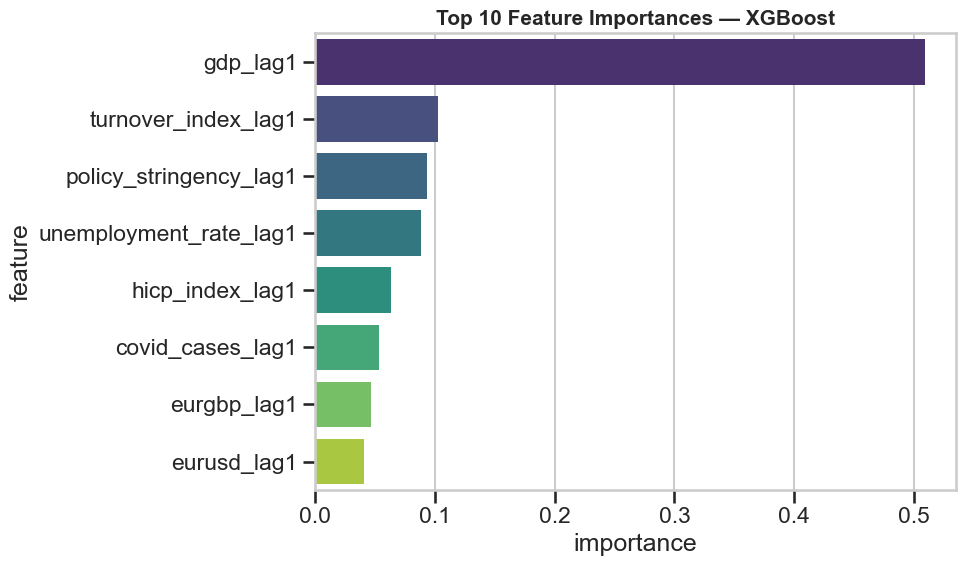

In [4]:
importances_df = None  # for later plotting

# --- Pick the best model (lowest RMSE) ---
best_model_name = eval_df.loc[eval_df["RMSE"].idxmin(), "model"]
best_model = models[best_model_name]
print(f"🏆 Best model based on RMSE: {best_model_name}")

# --- Make predictions ---
y_pred_best = best_model.predict(X_test)

# --- Feature importance for tree-based models ---
if hasattr(best_model, "feature_importances_"):
    importances_df = pd.DataFrame({
        "feature": feature_cols,
        "importance": best_model.feature_importances_
    }).sort_values("importance", ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=importances_df.head(10),
        x="importance", y="feature", palette="viridis"
    )
    plt.title(f"Top 10 Feature Importances — {best_model_name}", fontsize=15, weight="bold")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Feature importance not available for this model.")

In [5]:
# --- Save feature importancess ---

if importances_df is not None:
    out_path = "../outputs/feature_importances.csv"
    importances_df.to_csv(out_path, index=False)
    print(f"[INFO] Feature importances saved to {out_path}")

[INFO] Feature importances saved to ../outputs/feature_importances.csv


### 🟩 5. Country-Level Forecast Visualization

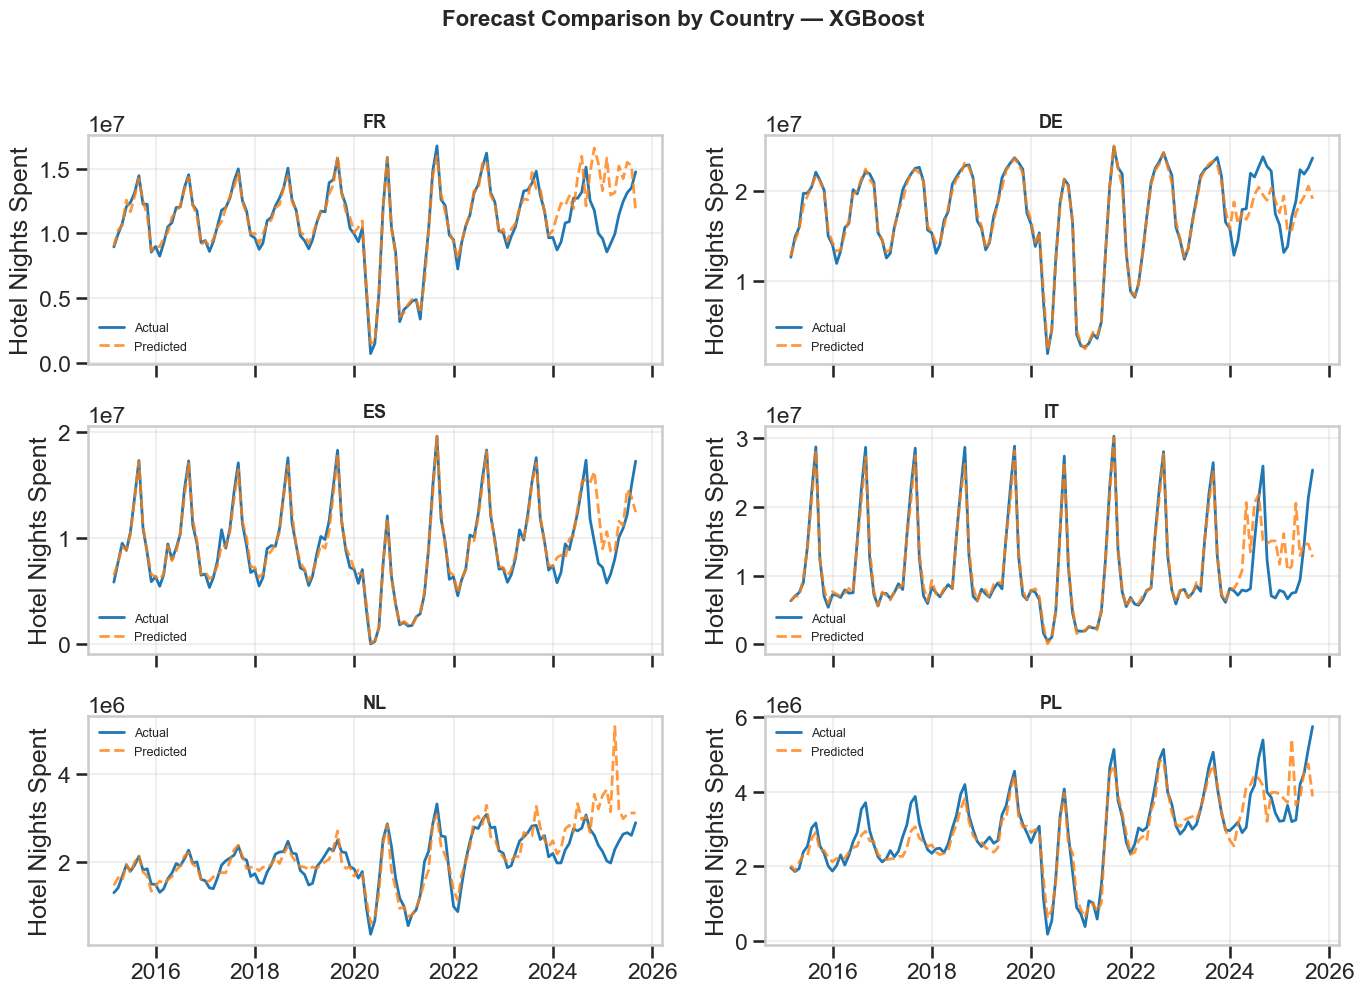

In [6]:
# --- Predict for all observations (train + test) to get full time series ---
panel_pred = data.copy()
panel_pred["yhat_ml"] = best_model.predict(panel_pred[feature_cols])

# --- Representative countries for visualization ---
representative_countries = ["FR", "DE", "ES", "IT", "NL", "PL"]

fig, axes = plt.subplots(3, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, country in enumerate(representative_countries):
    dfc = panel_pred[panel_pred["region"] == country]
    ax = axes[i]
    
    ax.plot(dfc["month"], dfc["nights_spent"], label="Actual", lw=2)
    ax.plot(dfc["month"], dfc["yhat_ml"], "--", label="Predicted", lw=2, alpha=0.8)
    
    ax.set_title(country, fontsize=13, weight="bold")
    ax.set_ylabel("Hotel Nights Spent")
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle(f"Forecast Comparison by Country — {best_model_name}",
             fontsize=16, fontweight="bold", y=1)
plt.tight_layout(rect=[0, 0, 1, 0.97])

### 🟩 6. Model Evaluation, SHAP Interpretation and Saving Outputs

Train size: 2782, Test size: 520
Feature columns: 8 — ['gdp_lag1', 'unemployment_rate_lag1', 'turnover_index_lag1', 'hicp_index_lag1', 'covid_cases_lag1']...


,model,RMSE,MAE
0,XGBoost,1.895007e+06,1.018364e+06



🏆 Best model confirmed: **XGBoost**
   RMSE = 1,895,007, MAE = 1,018,364
🔍 Explaining model: XGBoost


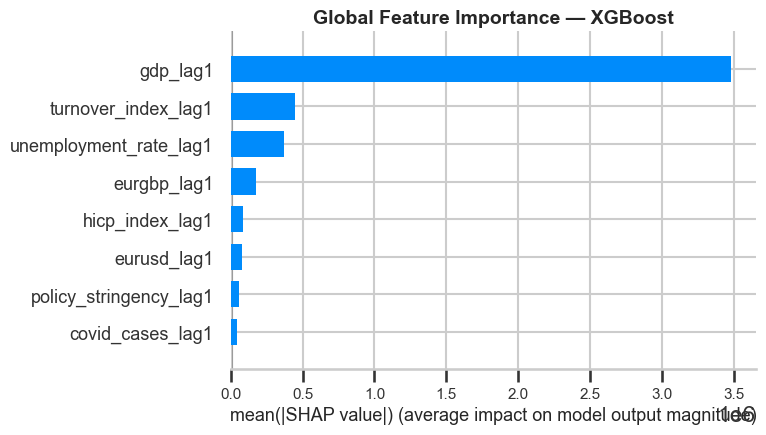

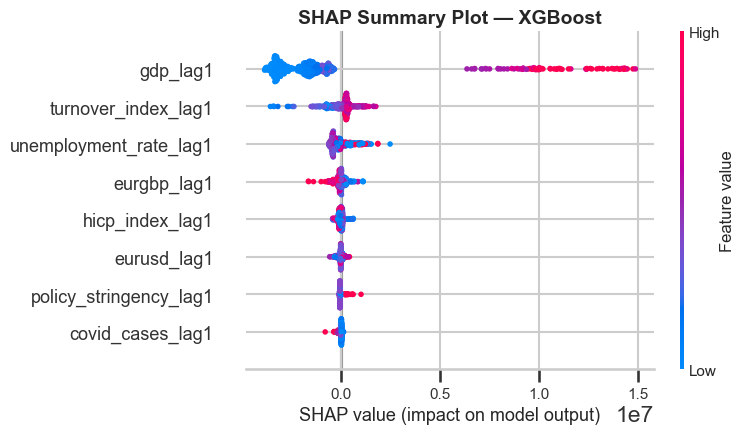


💾 Metrics saved to ../outputs/eval_metrics_final.csv


In [7]:
# ------------------------------------------------------------
# Sanity checks on splits
# ------------------------------------------------------------
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"Feature columns: {len(X_train.columns)} — {list(X_train.columns[:5])}...")

assert set(X_train.columns) == set(X_test.columns), "❌ Feature mismatch between train and test!"
assert y_train.notna().all(), "❌ Missing target values in train!"

# ------------------------------------------------------------
# 1️⃣  Evaluate model performance explicitly
# ------------------------------------------------------------
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)

eval_tbl = pd.DataFrame([{
    "model": best_model_name,
    "RMSE": rmse,
    "MAE": mae
}])
display(eval_tbl)

print(f"\n🏆 Best model confirmed: **{best_model_name}**")
print(f"   RMSE = {rmse:,.0f}, MAE = {mae:,.0f}")

# ------------------------------------------------------------
# 2️⃣  Model Interpretation with SHAP
# ------------------------------------------------------------
print(f"🔍 Explaining model: {best_model_name}")

# --- Sample for faster SHAP computation ---
rng = np.random.default_rng(42)
sample_idx = rng.choice(X_test.index, size=min(500, len(X_test)), replace=False)
X_sample = X_test.loc[sample_idx]

# --- Safe model-agnostic SHAP ---
explainer = shap.Explainer(best_model.predict, X_sample)
shap_values = explainer(X_sample)

# --- Global Feature Importance ---
plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    plot_type="bar",
    show=False
)
plt.title(f"Global Feature Importance — {best_model_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
plt.close()

# --- Detailed SHAP Summary (beeswarm) ---
plt.figure()
shap.summary_plot(
    shap_values,
    X_sample,
    show=False
)
plt.title(f"SHAP Summary Plot — {best_model_name}", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()
plt.close()

# --- Save evaluation results ---
output_path = Path("../outputs/eval_metrics_final.csv")
eval_tbl.to_csv(output_path, index=False)
print(f"\n💾 Metrics saved to {output_path}")

### 🟩 7. Forecast Error Visualization & Residual Analysis


📊 Visualizing forecast accuracy and residuals...
💾 Saving plots to: ../outputs/plots_20251023_1041


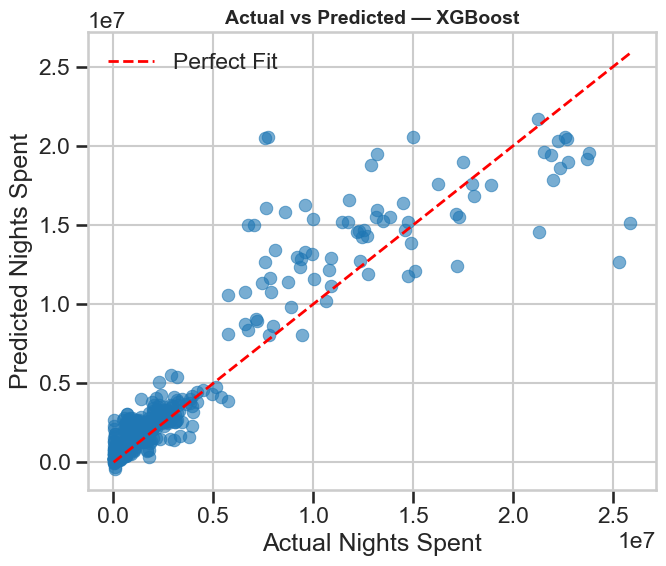

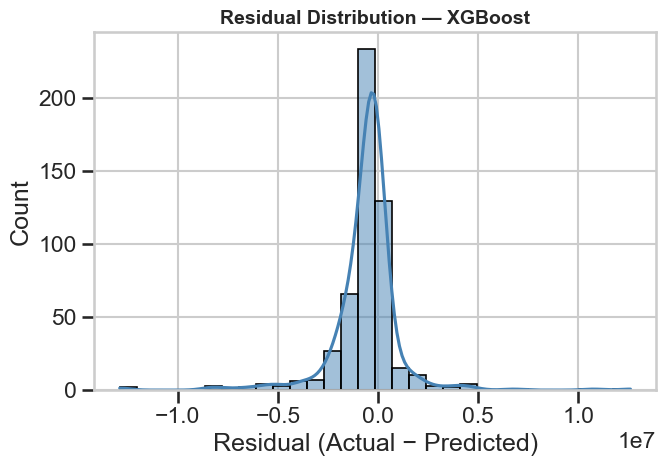

✅ Forecast error visualization complete.


In [8]:
print("\n📊 Visualizing forecast accuracy and residuals...")

# --- Combine actual vs predicted into one DataFrame ---
results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}, index=y_test.index)
results_df["Residuals"] = results_df["Actual"] - results_df["Predicted"]

# --- Create output folder ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
plots_dir = Path(f"../outputs/plots_{timestamp}")
plots_dir.mkdir(parents=True, exist_ok=True)
print(f"💾 Saving plots to: {plots_dir}")

# ------------------------------------------------------------
# 1️⃣ Actual vs Predicted Scatter Plot
# ------------------------------------------------------------
plt.figure(figsize=(7, 6))
sns.scatterplot(x="Actual", y="Predicted", data=results_df, alpha=0.6, edgecolor=None)
plt.plot([results_df["Actual"].min(), results_df["Actual"].max()],
         [results_df["Actual"].min(), results_df["Actual"].max()],
         "r--", lw=2, label="Perfect Fit")
plt.title(f"Actual vs Predicted — {best_model_name}", fontsize=14, fontweight="bold")
plt.xlabel("Actual Nights Spent")
plt.ylabel("Predicted Nights Spent")
plt.legend()
plt.tight_layout()
plt.savefig(plots_dir / "actual_vs_predicted.png", dpi=300)
plt.show()

# ------------------------------------------------------------
# 2️⃣ Residual Distribution
# ------------------------------------------------------------
plt.figure(figsize=(7, 5))
sns.histplot(results_df["Residuals"], bins=30, kde=True, color="steelblue")
plt.title(f"Residual Distribution — {best_model_name}", fontsize=14, fontweight="bold")
plt.xlabel("Residual (Actual − Predicted)")
plt.tight_layout()
plt.savefig(plots_dir / "residual_distribution.png", dpi=300)
plt.show()

# ------------------------------------------------------------
# 3️⃣ Residuals over Time
# ------------------------------------------------------------
if "month" in X_test.columns:
    tmp = X_test[["month"]].copy()
    tmp["Residuals"] = results_df["Residuals"].values
    tmp = tmp.sort_values("month")

    plt.figure(figsize=(10, 4))
    plt.plot(tmp["month"], tmp["Residuals"], marker="o", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"Residuals Over Time — {best_model_name}", fontsize=14, fontweight="bold")
    plt.ylabel("Residual (Actual − Predicted)")
    plt.xlabel("Month")
    plt.tight_layout()
    plt.savefig(plots_dir / "residuals_over_time.png", dpi=300)
    plt.show()

print("✅ Forecast error visualization complete.")

### 🟩 8. Save Key Plots & Evaluation Summary

In [9]:
print(f"\n💾 Finalizing outputs in: {plots_dir}")

# --- SHAP Plots ---
try:
    plt.figure()
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.title(f"Global Feature Importance — {best_model_name}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(plots_dir / "shap_global_importance.png", dpi=300)
    plt.close()

    plt.figure()
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP Summary Plot — {best_model_name}", fontsize=14, fontweight="bold")
    plt.tight_layout()
    plt.savefig(plots_dir / "shap_beeswarm.png", dpi=300)
    plt.close()

    print("✅ SHAP plots saved successfully.")
except Exception as e:
    print(f"[WARN] SHAP plots could not be saved: {e}")

# --- Save metrics ---
eval_tbl.to_csv(plots_dir / "eval_metrics.csv", index=False)
print("✅ Evaluation metrics saved.")
print("📁 All final outputs stored in:", plots_dir)


💾 Finalizing outputs in: ../outputs/plots_20251023_1041
✅ SHAP plots saved successfully.
✅ Evaluation metrics saved.
📁 All final outputs stored in: ../outputs/plots_20251023_1041
